In [1]:
!pip install roboflow torch torchvision matplotlib scikit-learn --quiet


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from roboflow import Roboflow


In [4]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="BDPx7dxrHkGkGN94CZBC")
project= rf.workspace("patrawadee").project("workshop2-object-classifcation")
version = project.version(1)
dataset = version.download("folder")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to workshop2-object-Classifcation-1 in folder:: 100%|█| 395/395 [00:00<00:00, 690.05it/s


In [5]:
print(dataset.location)

D:\fruitsclassification\workshop2-object-Classifcation-1


In [14]:
import os

base_dir = dataset.location
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir  = os.path.join(base_dir, "test")

print(train_dir, valid_dir, test_dir)


D:\fruitsclassification\workshop2-object-Classifcation-1\train D:\fruitsclassification\workshop2-object-Classifcation-1\valid D:\fruitsclassification\workshop2-object-Classifcation-1\test


In [15]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMG_SIZE = 224

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=transform)
test_data  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)

class_names = train_data.classes
print("Classes:", class_names)


Classes: ['apple', 'banana', 'cherry', 'strawberry']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


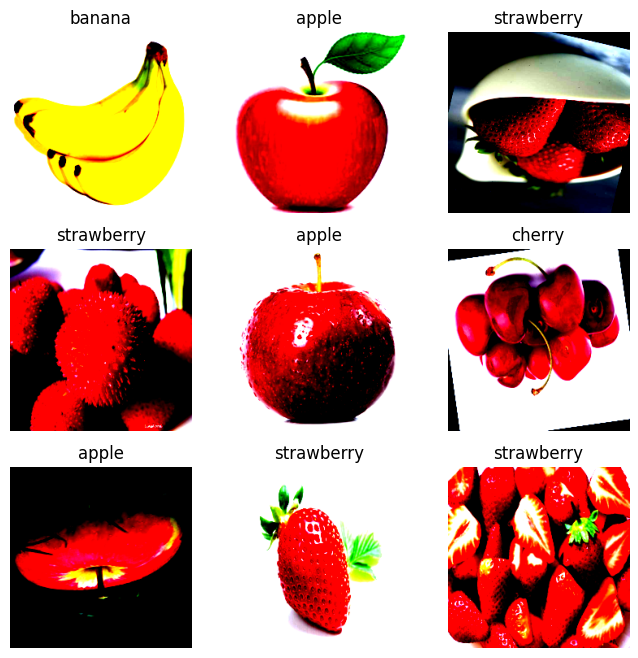

In [16]:
def show_images(data_loader):
    images, labels = next(iter(data_loader))
    plt.figure(figsize=(8, 8))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

show_images(train_loader)


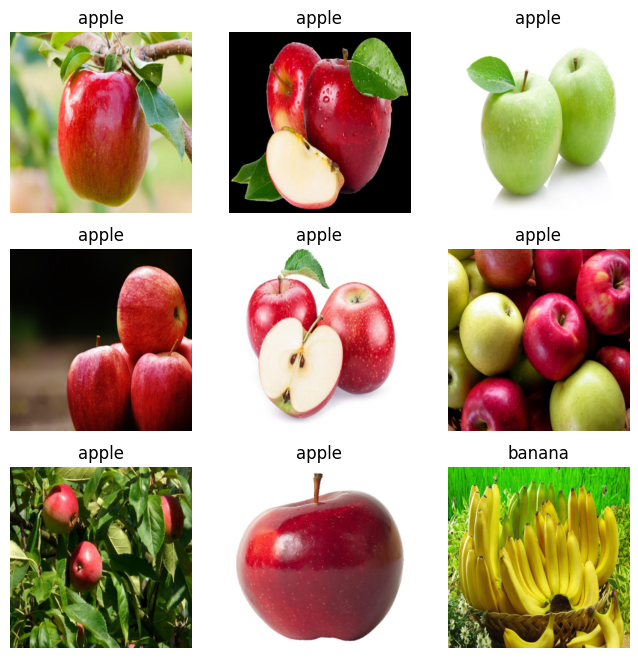

In [17]:
def show_images(data_loader):
    images, labels = next(iter(data_loader))
    plt.figure(figsize=(8, 8))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

show_images(val_loader)


In [18]:
from torchvision import models
import torch.nn as nn

# Load pretrained weights safely
weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
model = models.efficientnet_b0(weights=weights)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\ajitk/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:13<00:00, 1.60MB/s]


In [19]:
num_classes = len(class_names)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(model)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
print("Optimizer created successfully!")


Optimizer created successfully!


In [26]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/5, Loss: 0.0401
Epoch 2/5, Loss: 0.0736
Epoch 3/5, Loss: 0.0248
Epoch 4/5, Loss: 0.0236
Epoch 5/5, Loss: 0.0224


In [27]:
from sklearn.metrics import accuracy_score

model.eval()
preds, actual = [], []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        preds.extend(predicted.cpu().numpy())
        actual.extend(labels.numpy())

acc = accuracy_score(actual, preds)
print("Validation Accuracy:", acc)


Validation Accuracy: 0.875


In [29]:
torch.save(model.state_dict(), "fruits_efficientnet_b0.pth")
print("Model saved.")

Model saved.
